In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = '../Wimbledon_featured_matches.csv'
df = pd.read_csv(path)
# df.info()

In [3]:
target_match_ids = df['match_id'].unique().tolist()
# target_match_id = '2023-wimbledon-1701'
# filtered_data = df[df['match_id'] == target_match_id].copy()
# filtered_data = df.copy()

In [4]:
"""
计算综合势头得分函数
"""
def calculate_comprehensive_momentum(data, player_number, window_size=4):
    momentum_scores = [0] * len(data)
    consecutive_point_wins = 0  # 追踪连续得分
    consecutive_game_wins = 0  # 追踪连续获胜的局数
    previous_game_winner = None  # 追踪上一局的获胜者
    initial_break_point_value = 1  # 破发的基础势头得分增加值

    for i in range(1, len(data)):
        recent_data = data[max(0, i - window_size):i]
        momentum_score = 0

        for _, feature in recent_data.iterrows():
            # 基本的势头得分计算
            P_t = 1 if feature['point_victor'] == player_number else -1
            S_t = 1.2 if feature['server'] == player_number else 1.0
            base_momentum = P_t * S_t
            momentum_score += base_momentum
            break_point_value = initial_break_point_value  # 重置破发得分值

            # 连续得分补正（线性）
            if P_t == 1:
                consecutive_point_wins += 1
            else:
                consecutive_point_wins = 0  # 在失分时重置
            momentum_score += 0.03 * consecutive_point_wins  # 每连续获胜增加额外得分

            # 连续小局获胜补正（线性）
            if feature['game_victor']:
                current_game_winner = feature['game_victor']
                if current_game_winner == player_number:
                    if current_game_winner == previous_game_winner:
                        consecutive_game_wins += 1
                    else:
                        consecutive_game_wins = 0  # 重置连续获胜局数
                previous_game_winner = current_game_winner
                momentum_score += 0.2 * consecutive_game_wins  # 连续获胜局数的影响

            # 大比分差距补正（指数）
            if feature['set_victor']:
                player1_set = feature['p1_sets'] + 1 if feature['set_victor'] == player_number else feature['p1_sets']
                player2_set = feature['p2_sets'] + 1 if feature['set_victor'] == player_number else feature['p2_sets']
                diff = (player2_set - player1_set) * (-1 ** player_number)  # player1为-1， player2为+1
                momentum_score += 0.1 * (2 ** diff)

            # 小比分差距补正（线性）
            if feature['game_victor']:
                score_diff = abs(feature['p1_games'] - feature['p2_games'])
                momentum_score += 0.02 * score_diff * P_t

            # 错失破发点对破发的势头得分增加值的削弱
            if feature['p1_break_pt_missed'] == 1 or feature['p2_break_pt_missed'] == 1:
                break_point_value -= 0.1  # 削弱的权值

            # (被)破发的影响
            if feature['p1_break_pt_won'] == 1 or feature['p2_break_pt_won'] == 1:
                break_point_value = max(break_point_value, 0.1)
                momentum_score += break_point_value * P_t

            # 拍数和跑动距离的影响
            rally_factor = feature['rally_count'] / 30  # 归一化回合数
            distance_factor = (feature['p1_distance_run'] + feature['p2_distance_run']) / 122  # 归一化跑动距离
            momentum_score += 2.0 * rally_factor * distance_factor * P_t

        momentum_scores[i] = momentum_score

    return momentum_scores

特征：point_victor, server, game_victor, set_victor, p1_sets, p2_sets, p1_games, p2_games, p1_break_pt_missed, p2_break_pt_won, rally_count, p1_distance_run, p2_distance_run

Player 1 had a Negative shift at point number 55, during set 1, game 9. GET -4.861044808743169
Player 1 had a Positive shift at point number 63, during set 2, game 1. GET 4.364698360655738
Player 1 had a Negative shift at point number 124, during set 2, game 9. GET -4.2046010928961755
Player 1 had a Negative shift at point number 125, during set 2, game 9. GET -4.522684699453552
Player 1 had a Negative shift at point number 188, during set 3, game 5. GET -4.743472131147541
Player 1 had a Negative shift at point number 277, during set 4, game 9. GET -4.520220218579235
Player 1 had a Negative shift at point number 296, during set 4, game 12. GET -4.693735519125682
Player 2 had a Negative shift at point number 82, during set 2, game 4. GET -4.186937158469944


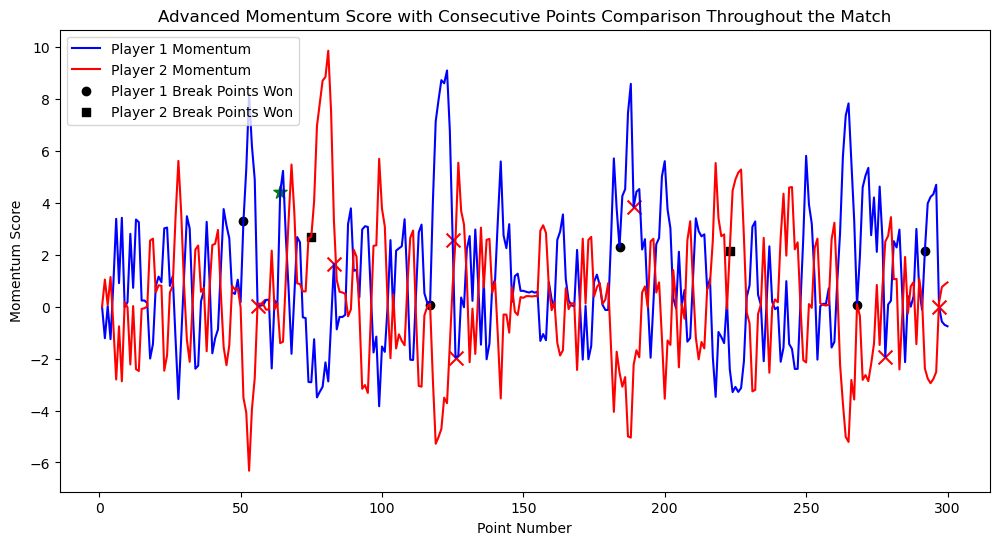

Player 1 had a Negative shift at point number 133, during set 3, game 3. GET -5.331875956284153
Player 1 had a Positive shift at point number 200, during set 3, game 13. GET 4.772139344262294
Player 2 had a Negative shift at point number 122, during set 3, game 1. GET -4.418167213114755
Player 2 had a Negative shift at point number 128, during set 3, game 2. GET -4.55813005464481
Player 2 had a Negative shift at point number 155, during set 3, game 7. GET -4.28407431693989
Player 2 had a Negative shift at point number 200, during set 3, game 13. GET -4.672139344262295


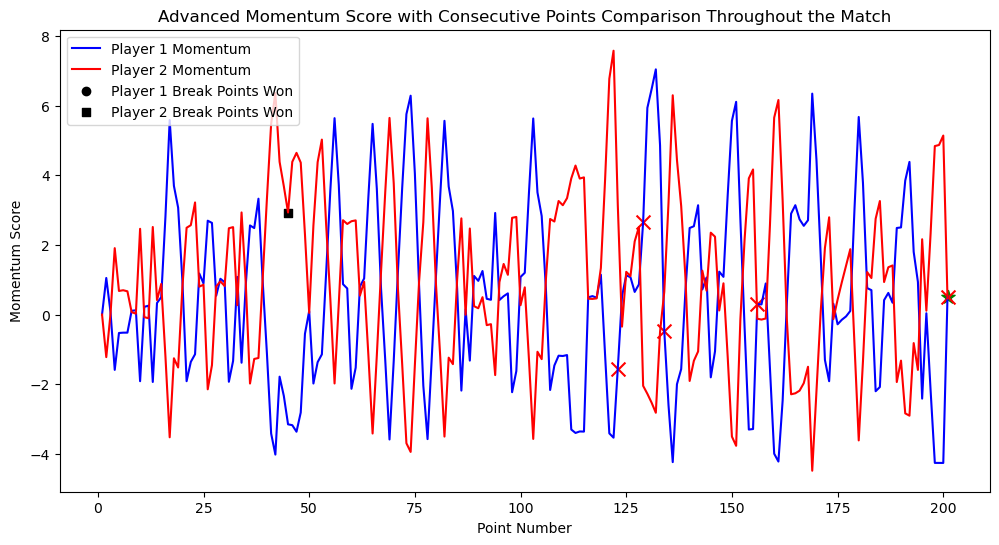

Player 1 had a Positive shift at point number 82, during set 2, game 7. GET 4.338414207650272
Player 1 had a Positive shift at point number 115, during set 3, game 5. GET 4.636779234972678
Player 1 had a Negative shift at point number 119, during set 3, game 6. GET -6.261792896174863
Player 1 had a Negative shift at point number 124, during set 3, game 7. GET -4.9047803278688535
Player 2 had a Positive shift at point number 43, during set 1, game 8. GET 5.195541530054645
Player 2 had a Positive shift at point number 49, during set 2, game 1. GET 5.657139890710383
Player 2 had a Positive shift at point number 78, during set 2, game 7. GET 5.41599344262295
Player 2 had a Negative shift at point number 82, during set 2, game 7. GET -5.908414207650274
Player 2 had a Positive shift at point number 83, during set 2, game 8. GET 4.567323497267759
Player 2 had a Negative shift at point number 87, during set 2, game 8. GET -4.603606010928962
Player 2 had a Negative shift at point number 115, du

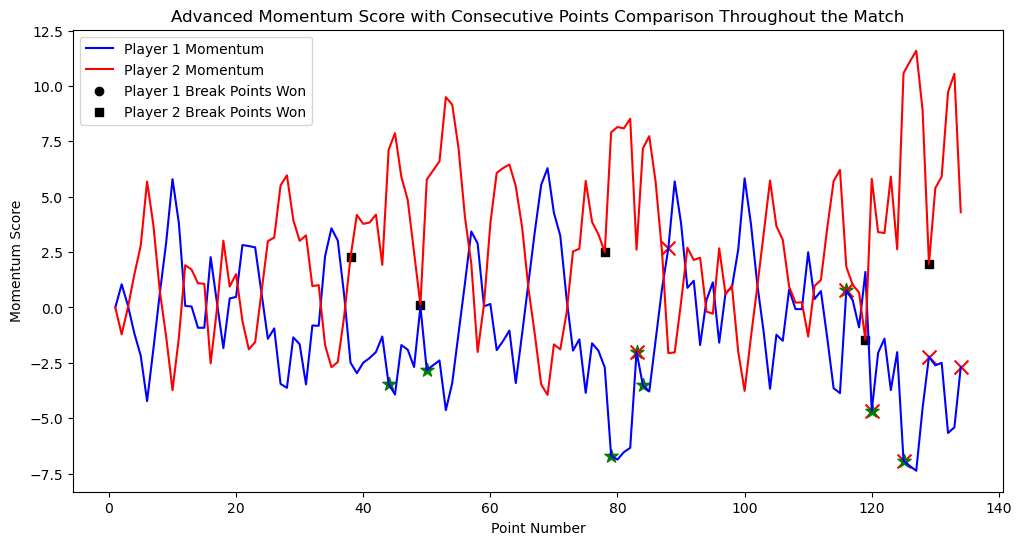

Player 1 had a Negative shift at point number 16, during set 1, game 4. GET -4.443397267759563
Player 1 had a Negative shift at point number 75, during set 2, game 4. GET -4.538039344262296
Player 1 had a Negative shift at point number 80, during set 2, game 5. GET -4.487960109289617
Player 1 had a Negative shift at point number 109, during set 2, game 9. GET -4.171426775956283
Player 1 had a Negative shift at point number 135, during set 3, game 4. GET -4.8373868852459
Player 1 had a Negative shift at point number 179, during set 4, game 1. GET -4.8562448087431695
Player 2 had a Negative shift at point number 59, during set 2, game 1. GET -4.054119125683061
Player 2 had a Positive shift at point number 62, during set 2, game 2. GET 5.702769398907105
Player 2 had a Negative shift at point number 101, during set 2, game 7. GET -5.401337704918031
Player 2 had a Negative shift at point number 144, during set 3, game 6. GET -4.686550819672131
Player 2 had a Negative shift at point number 2

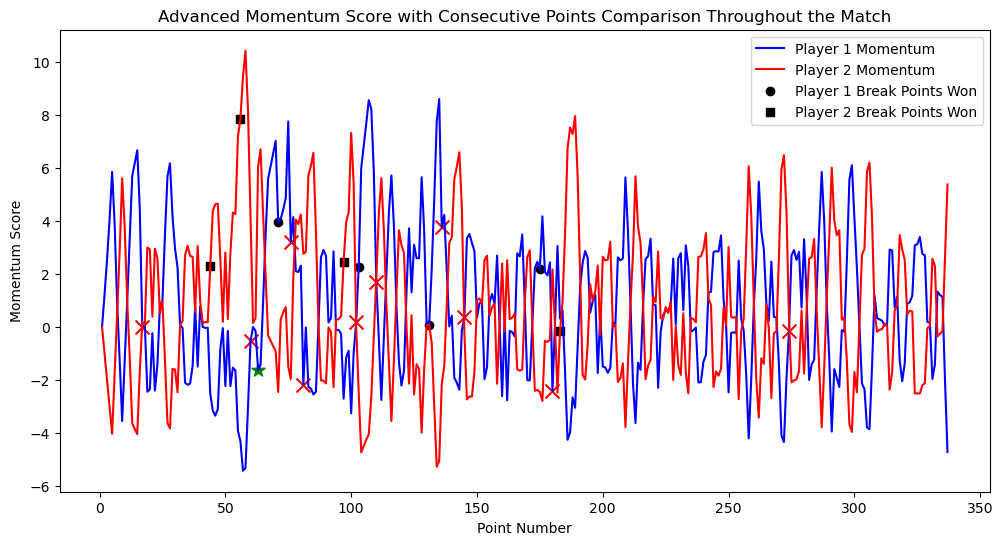

Player 1 had a Negative shift at point number 33, during set 1, game 5. GET -4.07231475409836
Player 1 had a Positive shift at point number 85, during set 2, game 4. GET 4.98503224043716
Player 1 had a Negative shift at point number 89, during set 2, game 5. GET -6.894598907103825
Player 1 had a Negative shift at point number 91, during set 2, game 5. GET -4.677194535519126
Player 1 had a Positive shift at point number 95, during set 2, game 6. GET 4.164253005464481
Player 1 had a Negative shift at point number 99, during set 2, game 6. GET -4.484731693989072
Player 1 had a Negative shift at point number 129, during set 3, game 3. GET -4.046173770491803
Player 1 had a Negative shift at point number 130, during set 3, game 3. GET -4.922962295081966
Player 1 had a Negative shift at point number 147, during set 3, game 7. GET -4.653513661202187
Player 1 had a Negative shift at point number 203, during set 4, game 4. GET -4.917674316939889
Player 1 had a Negative shift at point number 208,

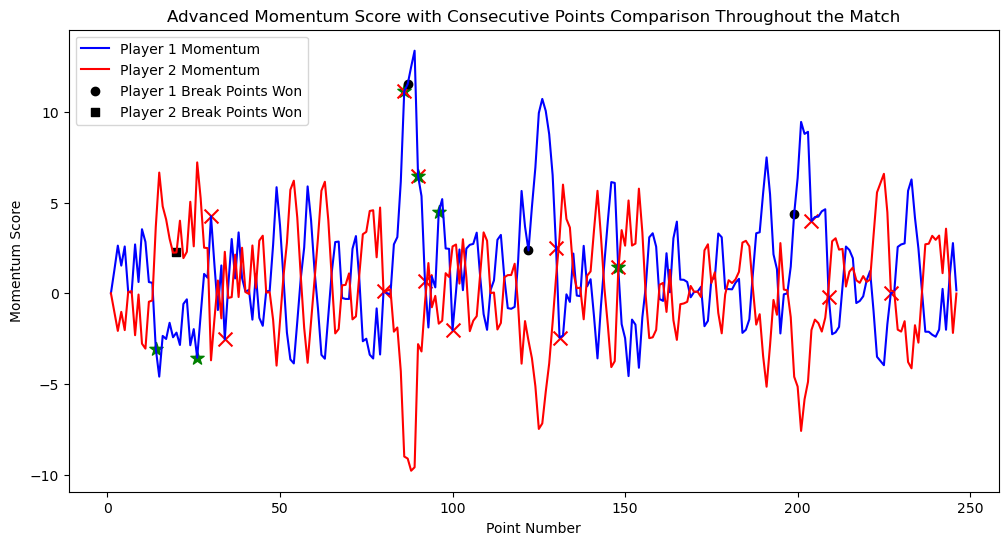

Player 1 had a Positive shift at point number 27, during set 1, game 5. GET 4.164605464480873
Player 1 had a Positive shift at point number 37, during set 1, game 7. GET 6.161016939890712
Player 1 had a Negative shift at point number 41, during set 1, game 7. GET -6.122144808743169
Player 1 had a Negative shift at point number 143, during set 3, game 6. GET -4.2273704918032795
Player 1 had a Negative shift at point number 317, during set 5, game 6. GET -4.302404371584699
Player 1 had a Positive shift at point number 321, during set 5, game 7. GET 4.02898087431694
Player 1 had a Positive shift at point number 323, during set 5, game 7. GET 4.1121786885245895
Player 1 had a Negative shift at point number 325, during set 5, game 7. GET -4.650244808743171
Player 2 had a Negative shift at point number 136, during set 3, game 4. GET -4.824432786885245
Player 2 had a Negative shift at point number 196, during set 4, game 2. GET -4.474232240437159


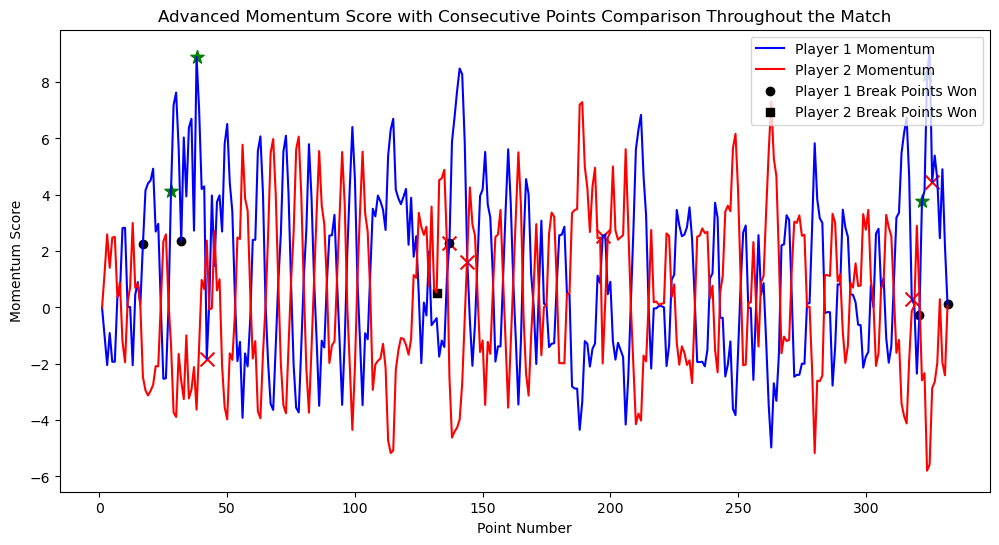

Player 1 had a Negative shift at point number 113, during set 2, game 7. GET -4.352152459016393
Player 1 had a Negative shift at point number 159, during set 3, game 2. GET -4.554638797814207
Player 1 had a Negative shift at point number 192, during set 3, game 8. GET -4.246358469945355


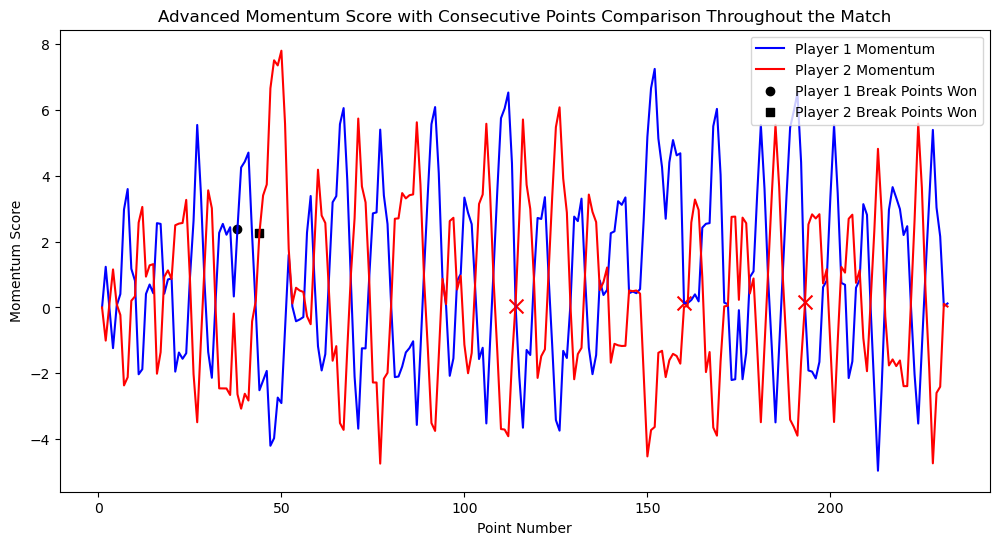

Player 1 had a Negative shift at point number 123, during set 2, game 11. GET -4.271712568306011
Player 2 had a Positive shift at point number 100, during set 2, game 7. GET 4.49713387978142
Player 2 had a Positive shift at point number 105, during set 2, game 8. GET 4.855467759562841


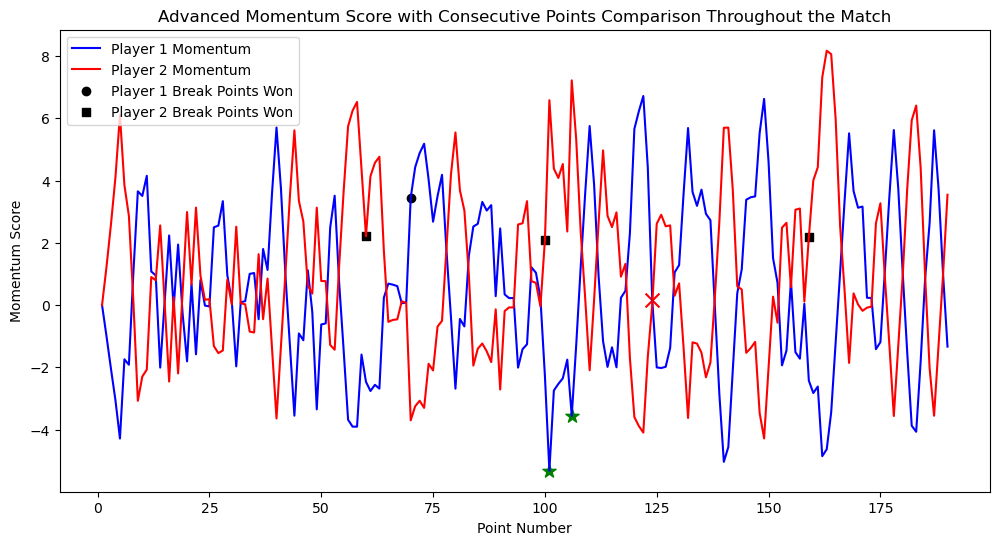

Player 1 had a Negative shift at point number 78, during set 2, game 4. GET -4.904709836065574
Player 1 had a Negative shift at point number 103, during set 3, game 1. GET -4.791630601092896
Player 1 had a Positive shift at point number 208, during set 4, game 10. GET 4.144853551912568
Player 1 had a Negative shift at point number 212, during set 4, game 10. GET -4.952775956284152
Player 2 had a Positive shift at point number 32, during set 1, game 5. GET 4.000793442622951
Player 2 had a Positive shift at point number 37, during set 1, game 6. GET 4.539271584699454
Player 2 had a Negative shift at point number 166, during set 4, game 3. GET -5.058255737704918


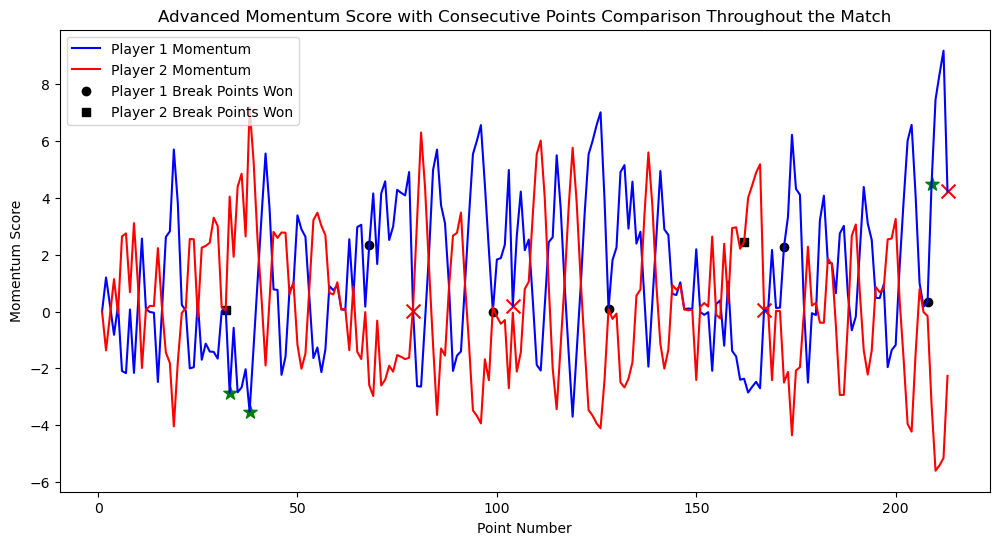

Player 1 had a Positive shift at point number 45, during set 1, game 7. GET 5.299999999999999
Player 1 had a Positive shift at point number 51, during set 1, game 8. GET 6.33
Player 1 had a Negative shift at point number 55, during set 1, game 8. GET -4.609999999999999
Player 1 had a Positive shift at point number 56, during set 2, game 1. GET 4.1899999999999995
Player 1 had a Negative shift at point number 64, during set 2, game 2. GET -4.770000000000001
Player 1 had a Negative shift at point number 87, during set 2, game 5. GET -4.5200000000000005
Player 1 had a Positive shift at point number 92, during set 2, game 6. GET 5.08
Player 1 had a Negative shift at point number 96, during set 2, game 6. GET -5.46
Player 1 had a Negative shift at point number 181, during set 3, game 7. GET -4.65
Player 1 had a Positive shift at point number 185, during set 3, game 8. GET 4.09
Player 1 had a Negative shift at point number 248, during set 4, game 4. GET -4.66
Player 1 had a Positive shift at 

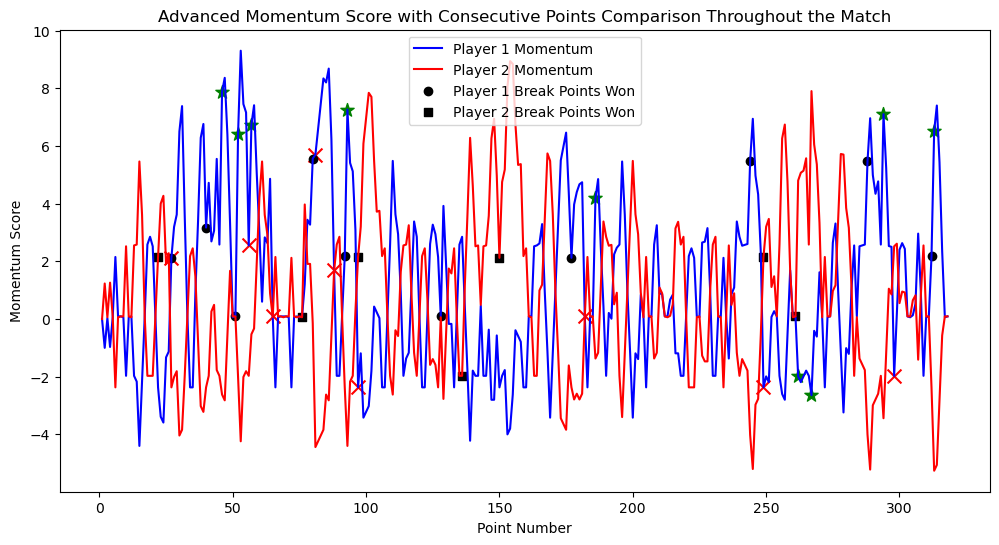

Player 2 had a Negative shift at point number 56, during set 1, game 9. GET -4.26
Player 2 had a Positive shift at point number 155, during set 3, game 4. GET 5.67
Player 2 had a Negative shift at point number 159, during set 3, game 4. GET -4.010000000000001
Player 2 had a Positive shift at point number 160, during set 3, game 5. GET 7.540000000000001
Player 2 had a Negative shift at point number 167, during set 3, game 6. GET -4.5200000000000005
Player 2 had a Negative shift at point number 168, during set 3, game 6. GET -5.710000000000001


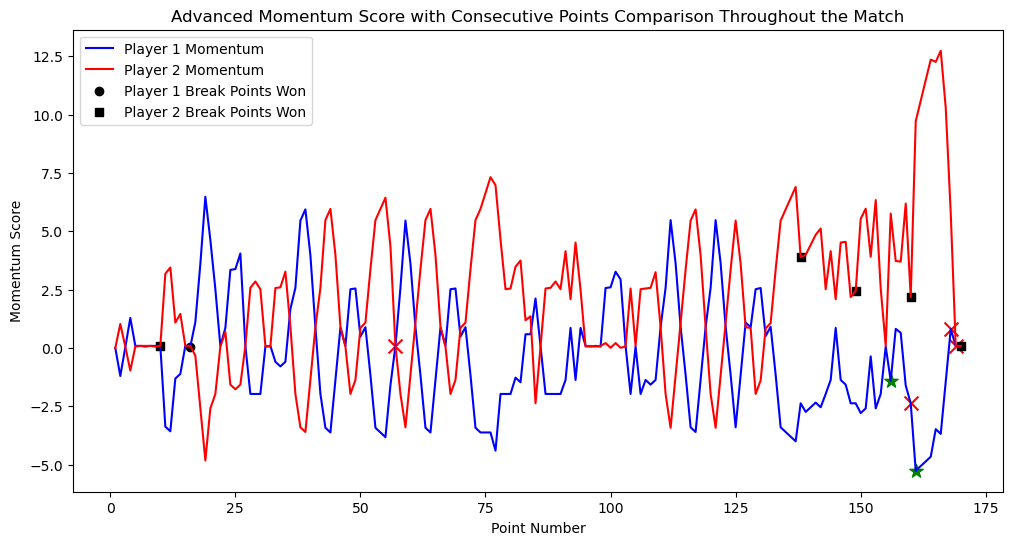

Player 1 had a Positive shift at point number 128, during set 2, game 8. GET 4.389586885245903
Player 1 had a Negative shift at point number 132, during set 2, game 8. GET -4.915584699453554
Player 1 had a Positive shift at point number 192, during set 3, game 10. GET 4.626372131147542
Player 1 had a Negative shift at point number 205, during set 3, game 12. GET -6.99001092896175
Player 1 had a Negative shift at point number 211, during set 4, game 1. GET -6.173168852459017
Player 2 had a Negative shift at point number 49, during set 1, game 7. GET -4.694084153005464
Player 2 had a Positive shift at point number 51, during set 1, game 8. GET 4.1438688524590175
Player 2 had a Negative shift at point number 55, during set 1, game 8. GET -4.743953551912568
Player 2 had a Positive shift at point number 77, during set 2, game 1. GET 4.853993442622951
Player 2 had a Negative shift at point number 86, during set 2, game 2. GET -4.628196174863387
Player 2 had a Negative shift at point number 1

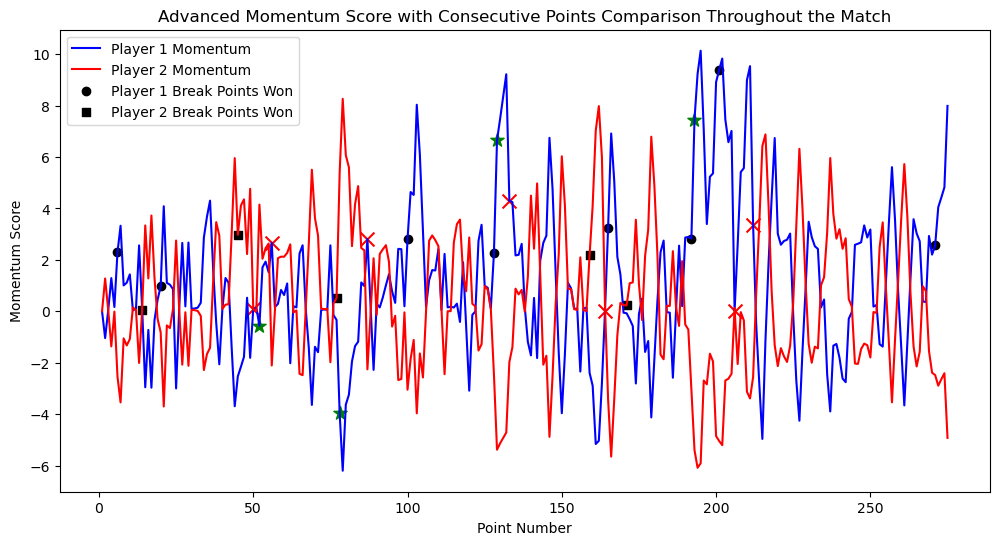

Player 1 had a Positive shift at point number 10, during set 1, game 3. GET 4.358888524590164
Player 1 had a Negative shift at point number 14, during set 1, game 3. GET -4.7749956284153
Player 1 had a Positive shift at point number 249, during set 4, game 2. GET 4.126479781420765
Player 1 had a Negative shift at point number 258, during set 4, game 3. GET -4.4699606557377045
Player 2 had a Negative shift at point number 32, during set 1, game 6. GET -7.010754098360655
Player 2 had a Negative shift at point number 92, during set 2, game 6. GET -4.2474420765027325
Player 2 had a Negative shift at point number 187, during set 3, game 6. GET -5.102850273224044
Player 2 had a Negative shift at point number 231, during set 3, game 13. GET -4.286822950819673


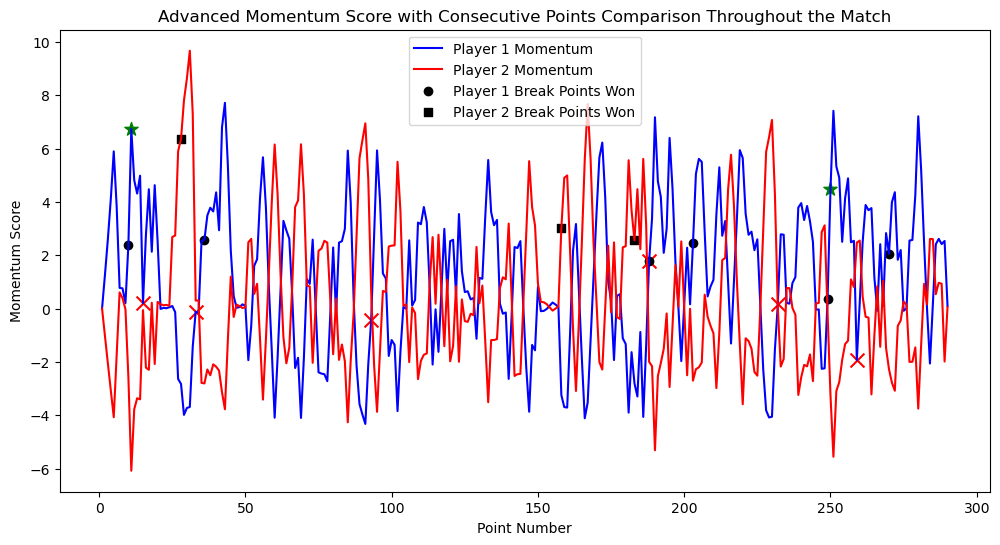

Player 1 had a Negative shift at point number 20, during set 1, game 4. GET -4.753721311475408
Player 1 had a Negative shift at point number 26, during set 1, game 5. GET -5.1741737704918025
Player 1 had a Positive shift at point number 72, during set 2, game 2. GET 4.064273770491804
Player 1 had a Negative shift at point number 81, during set 2, game 3. GET -4.498406010928963
Player 1 had a Negative shift at point number 168, during set 3, game 12. GET -4.403356830601093


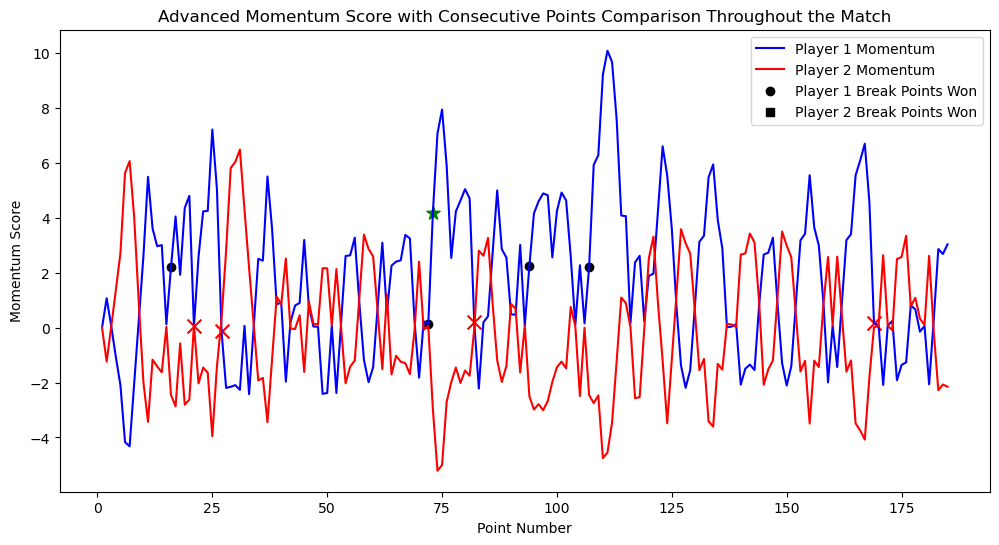

Player 1 had a Negative shift at point number 51, during set 1, game 10. GET -4.136416393442623
Player 1 had a Negative shift at point number 120, during set 2, game 8. GET -4.288937704918033
Player 2 had a Positive shift at point number 98, during set 2, game 4. GET 4.357632240437158
Player 2 had a Negative shift at point number 104, during set 2, game 5. GET -4.167760109289617
Player 2 had a Negative shift at point number 146, during set 3, game 2. GET -4.867111475409835
Player 2 had a Negative shift at point number 151, during set 3, game 3. GET -5.185187431693989


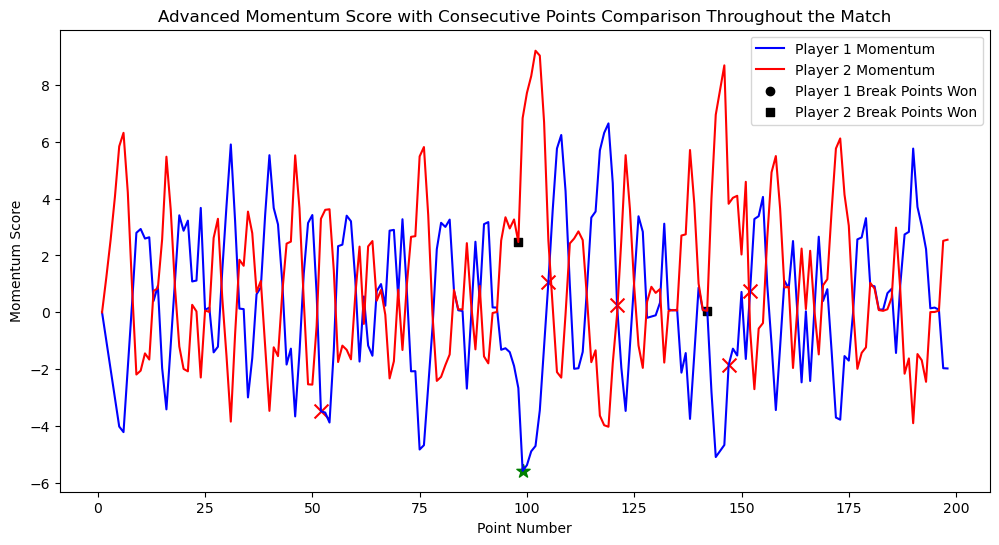

Player 1 had a Positive shift at point number 38, during set 1, game 7. GET 5.547479781420765
Player 1 had a Negative shift at point number 61, during set 2, game 2. GET -4.04681475409836
Player 1 had a Negative shift at point number 71, during set 2, game 4. GET -4.328863934426229
Player 2 had a Negative shift at point number 10, during set 1, game 2. GET -4.1650628415300535
Player 2 had a Positive shift at point number 34, during set 1, game 7. GET 4.681627322404372
Player 2 had a Negative shift at point number 38, during set 1, game 7. GET -8.567479781420765
Player 2 had a Positive shift at point number 61, during set 2, game 2. GET 5.07681475409836
Player 2 had a Negative shift at point number 69, during set 2, game 3. GET -4.48931693989071
Player 2 had a Positive shift at point number 71, during set 2, game 4. GET 6.95886393442623
Player 2 had a Negative shift at point number 75, during set 2, game 4. GET -5.081129508196722
Player 2 had a Negative shift at point number 80, during 

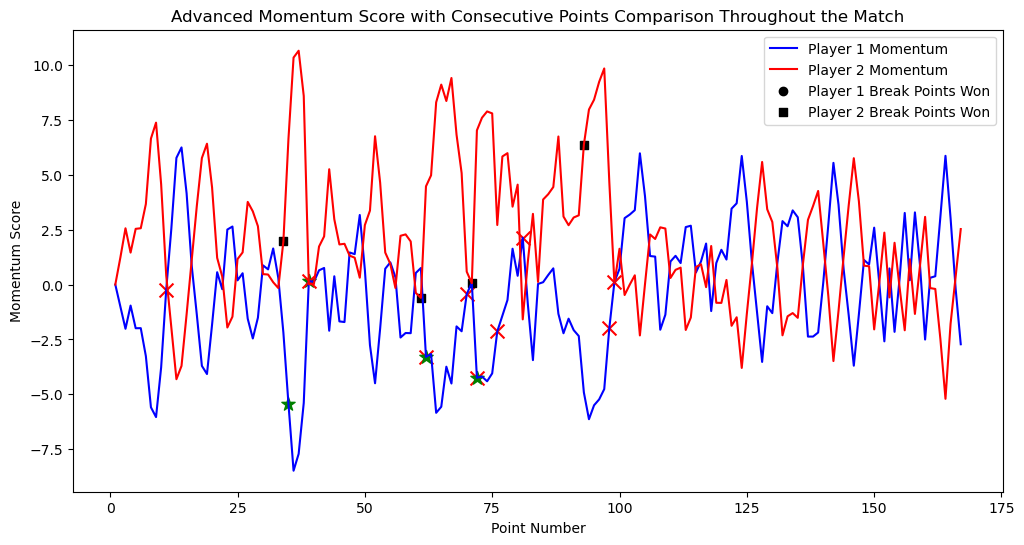

Player 1 had a Negative shift at point number 90, during set 2, game 5. GET -5.230927868852457
Player 1 had a Negative shift at point number 138, during set 3, game 4. GET -4.881154098360654
Player 1 had a Positive shift at point number 142, during set 3, game 5. GET 4.238655737704919
Player 1 had a Positive shift at point number 181, during set 4, game 2. GET 4.485705464480874
Player 2 had a Positive shift at point number 49, during set 1, game 9. GET 4.231475956284153
Player 2 had a Negative shift at point number 53, during set 1, game 9. GET -5.318261202185791
Player 2 had a Positive shift at point number 57, during set 2, game 1. GET 4.367934972677595


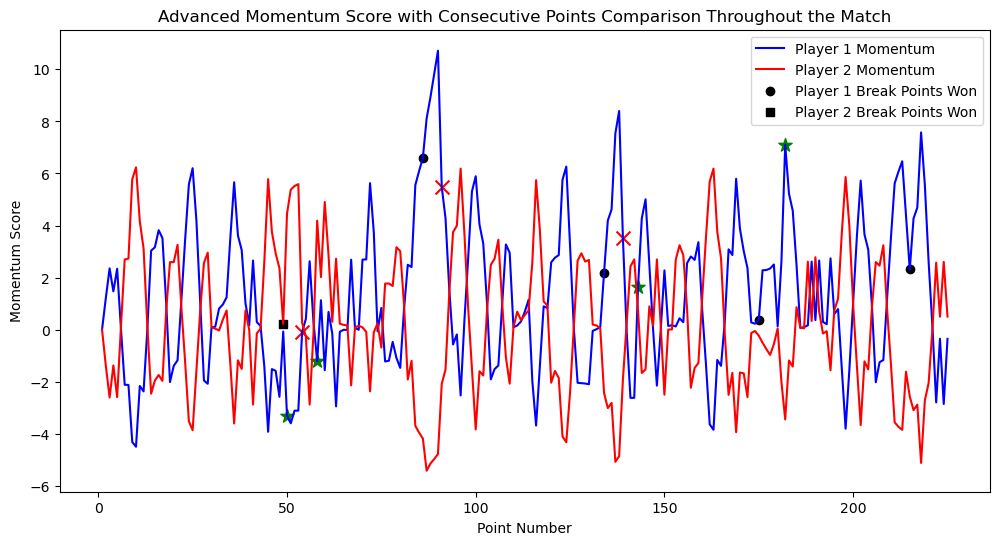

Player 1 had a Positive shift at point number 10, during set 1, game 2. GET 4.129218032786885
Player 1 had a Negative shift at point number 66, during set 1, game 9. GET -4.988950819672132
Player 1 had a Positive shift at point number 74, during set 2, game 1. GET 5.80894918032787
Player 1 had a Negative shift at point number 149, during set 2, game 13. GET -4.466130601092895
Player 2 had a Positive shift at point number 115, during set 2, game 9. GET 4.374206010928962
Player 2 had a Positive shift at point number 120, during set 2, game 10. GET 4.55337213114754
Player 2 had a Negative shift at point number 124, during set 2, game 10. GET -4.47535519125683
Player 2 had a Positive shift at point number 149, during set 2, game 13. GET 4.096130601092896
Player 2 had a Negative shift at point number 232, during set 4, game 1. GET -4.273051366120218
Player 2 had a Negative shift at point number 238, during set 4, game 2. GET -4.751366666666667


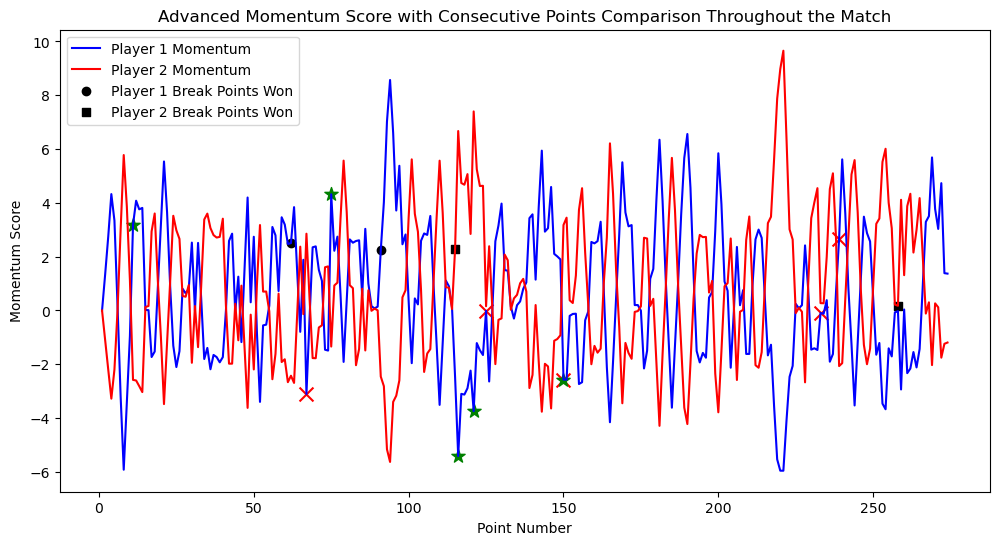

Player 1 had a Negative shift at point number 94, during set 2, game 5. GET -8.42560655737705
Player 1 had a Negative shift at point number 120, during set 2, game 8. GET -4.676710382513662
Player 1 had a Negative shift at point number 121, during set 2, game 8. GET -4.0814469945355185


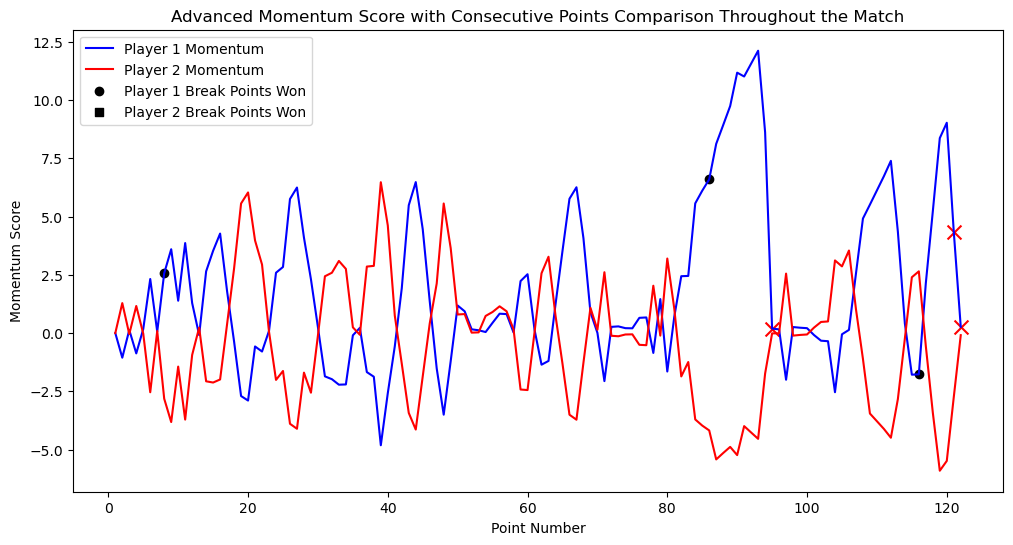

Player 1 had a Negative shift at point number 212, during set 4, game 9. GET -4.592207650273225
Player 1 had a Negative shift at point number 218, during set 4, game 10. GET -4.586932240437157
Player 1 had a Negative shift at point number 235, during set 5, game 2. GET -6.307403278688525
Player 1 had a Positive shift at point number 237, during set 5, game 3. GET 5.860030054644809
Player 1 had a Negative shift at point number 241, during set 5, game 3. GET -4.050377595628414
Player 2 had a Negative shift at point number 21, during set 1, game 5. GET -4.555715846994536
Player 2 had a Negative shift at point number 55, during set 2, game 2. GET -4.542319672131148
Player 2 had a Negative shift at point number 173, during set 4, game 2. GET -4.57673606557377
Player 2 had a Negative shift at point number 183, during set 4, game 4. GET -4.009249180327868
Player 2 had a Positive shift at point number 258, during set 5, game 7. GET 4.38223387978142


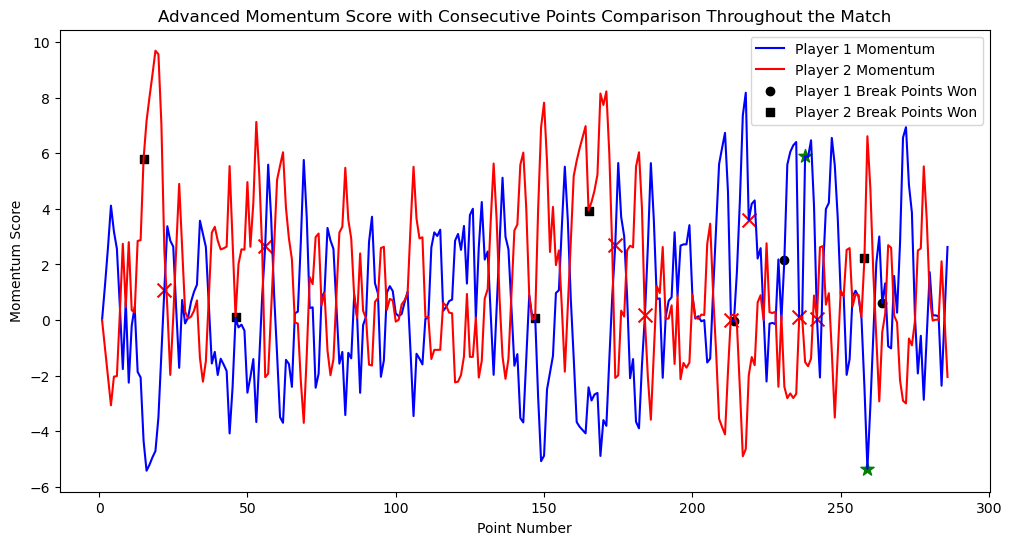

Player 1 had a Negative shift at point number 88, during set 2, game 1. GET -4.188670491803277
Player 1 had a Negative shift at point number 161, during set 2, game 10. GET -5.488614207650272
Player 1 had a Positive shift at point number 165, during set 3, game 1. GET 5.78760655737705
Player 1 had a Negative shift at point number 173, during set 3, game 2. GET -6.065398907103824
Player 1 had a Positive shift at point number 177, during set 3, game 3. GET 7.14631912568306


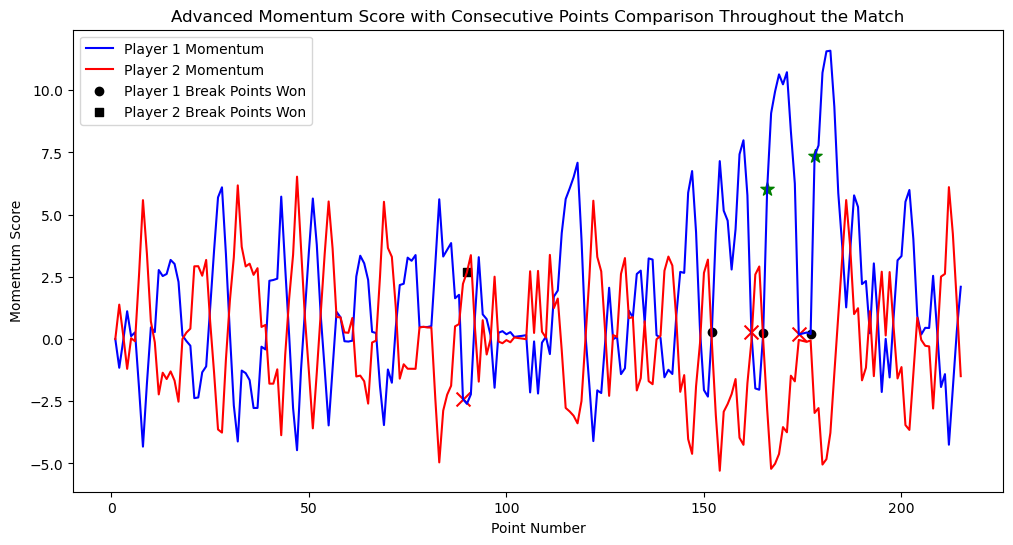

Player 1 had a Positive shift at point number 79, during set 2, game 6. GET 4.754129508196721
Player 1 had a Negative shift at point number 92, during set 2, game 8. GET -4.5095480874316936
Player 1 had a Negative shift at point number 122, during set 3, game 3. GET -4.497467759562841
Player 1 had a Negative shift at point number 132, during set 3, game 5. GET -4.358567213114755
Player 1 had a Positive shift at point number 149, during set 4, game 1. GET 6.190986338797815
Player 1 had a Positive shift at point number 180, during set 4, game 7. GET 4.059367759562842
Player 1 had a Negative shift at point number 189, during set 4, game 8. GET -4.505313114754099
Player 2 had a Positive shift at point number 36, during set 1, game 7. GET 4.024467213114754
Player 2 had a Negative shift at point number 44, during set 1, game 8. GET -4.5026808743169395
Player 2 had a Negative shift at point number 55, during set 2, game 1. GET -4.29813387978142
Player 2 had a Negative shift at point number 77

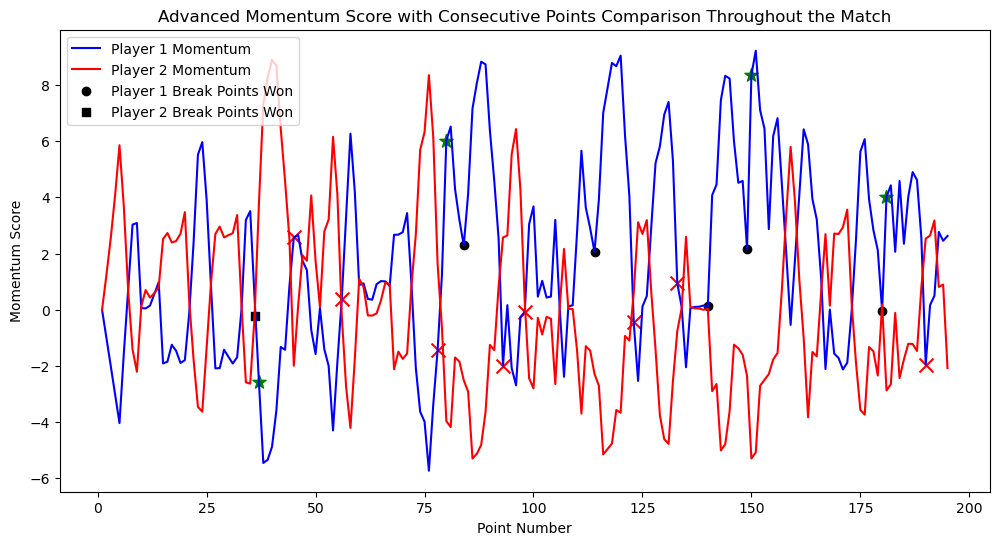

Player 1 had a Negative shift at point number 70, during set 1, game 12. GET -4.087789617486338
Player 1 had a Positive shift at point number 77, during set 2, game 2. GET 4.838918032786884
Player 1 had a Negative shift at point number 81, during set 2, game 2. GET -4.434322950819672
Player 1 had a Negative shift at point number 325, during set 5, game 9. GET -4.466679234972678
Player 2 had a Positive shift at point number 284, during set 5, game 2. GET 4.114624590163935


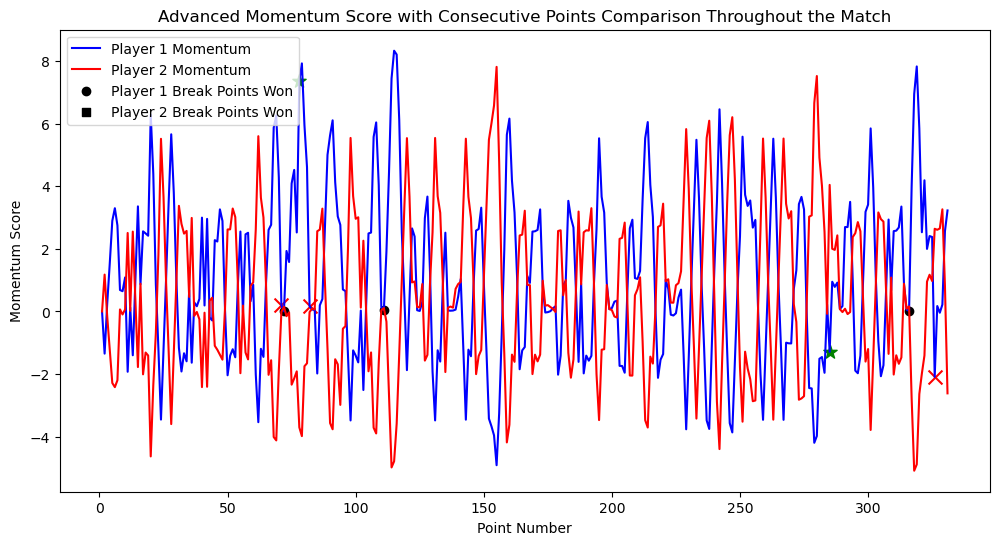

Player 1 had a Positive shift at point number 156, during set 2, game 13. GET 4.713988524590164
Player 1 had a Negative shift at point number 166, during set 3, game 2. GET -4.4116639344262305
Player 1 had a Positive shift at point number 217, during set 4, game 1. GET 4.383259016393443
Player 1 had a Negative shift at point number 221, during set 4, game 1. GET -4.575605464480876
Player 2 had a Negative shift at point number 41, during set 1, game 9. GET -4.396615300546448
Player 2 had a Positive shift at point number 80, during set 2, game 2. GET 4.730737704918032
Player 2 had a Negative shift at point number 156, during set 2, game 13. GET -5.1439885245901635
Player 2 had a Positive shift at point number 257, during set 4, game 8. GET 4.485653551912568
Player 2 had a Negative shift at point number 265, during set 4, game 9. GET -4.718537158469945


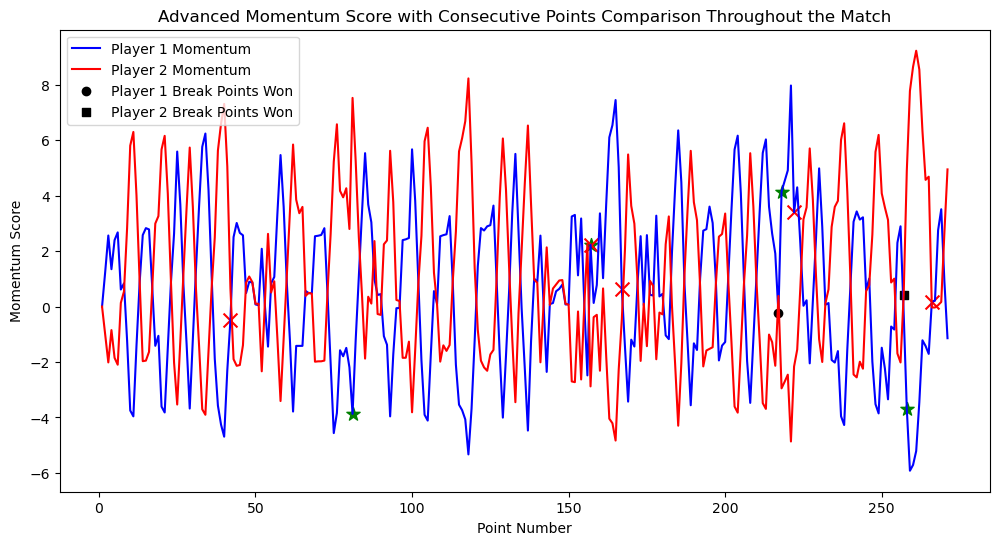

Player 1 had a Negative shift at point number 37, during set 1, game 6. GET -4.313066120218578
Player 1 had a Positive shift at point number 131, during set 2, game 10. GET 4.326383606557377
Player 1 had a Negative shift at point number 135, during set 2, game 10. GET -4.611128961748635
Player 1 had a Positive shift at point number 164, during set 3, game 7. GET 4.657035519125682


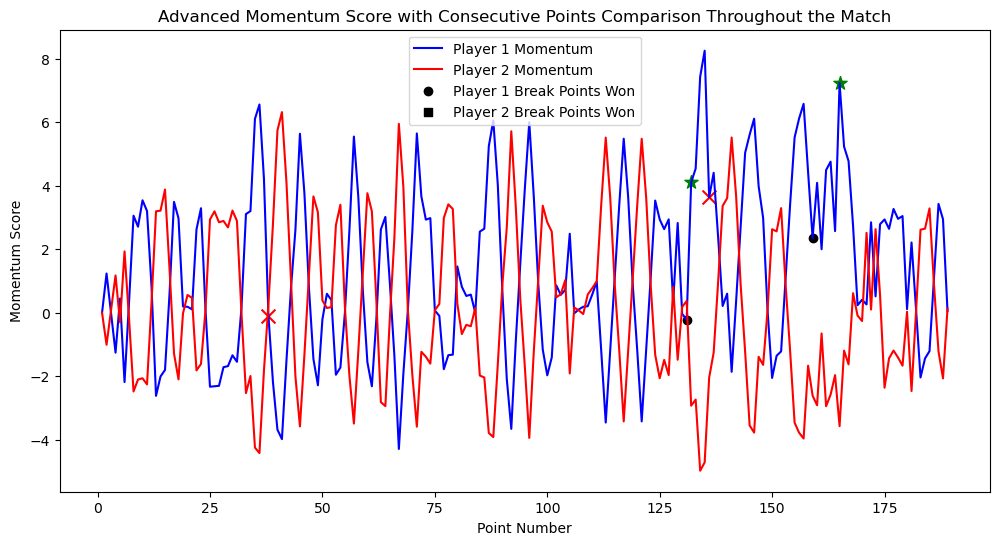

Player 1 had a Negative shift at point number 24, during set 1, game 5. GET -4.529271584699452
Player 1 had a Negative shift at point number 181, during set 4, game 4. GET -4.297274316939889
Player 1 had a Negative shift at point number 239, during set 5, game 2. GET -4.689794535519125
Player 1 had a Positive shift at point number 241, during set 5, game 3. GET 4.1153398907103815
Player 1 had a Positive shift at point number 247, during set 5, game 4. GET 6.088734426229509
Player 1 had a Positive shift at point number 261, during set 5, game 5. GET 5.767957923497267
Player 1 had a Negative shift at point number 265, during set 5, game 5. GET -6.0980387978142065
Player 2 had a Negative shift at point number 95, during set 2, game 6. GET -4.5972
Player 2 had a Positive shift at point number 99, during set 2, game 7. GET 6.065317486338799
Player 2 had a Negative shift at point number 103, during set 2, game 7. GET -6.6154316939890725
Player 2 had a Negative shift at point number 104, duri

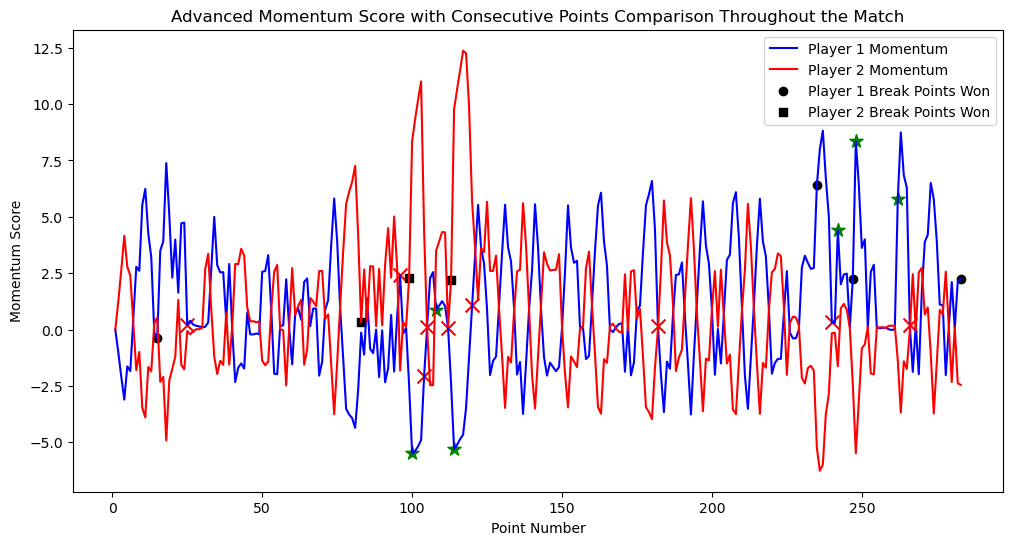

Player 1 had a Negative shift at point number 56, during set 2, game 1. GET -4.592720218579235
Player 1 had a Negative shift at point number 76, during set 2, game 5. GET -4.5053590163934425
Player 1 had a Positive shift at point number 133, during set 3, game 7. GET 4.571207650273223
Player 1 had a Negative shift at point number 139, during set 3, game 8. GET -4.4861109289617485
Player 1 had a Negative shift at point number 141, during set 3, game 8. GET -4.501483606557377
Player 1 had a Positive shift at point number 145, during set 4, game 1. GET 6.389215846994535
Player 1 had a Negative shift at point number 149, during set 4, game 1. GET -6.7249191256830585
Player 1 had a Negative shift at point number 159, during set 4, game 2. GET -6.335594535519125
Player 1 had a Negative shift at point number 191, during set 4, game 8. GET -5.16139781420765
Player 2 had a Negative shift at point number 101, during set 3, game 1. GET -6.497633333333335


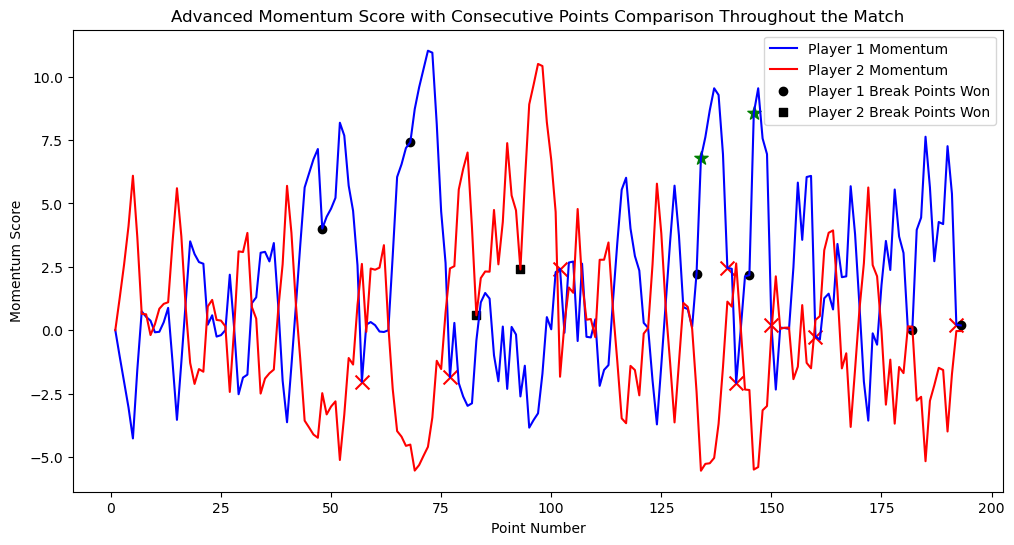

Player 1 had a Positive shift at point number 10, during set 1, game 2. GET 4.231738251366121
Player 1 had a Negative shift at point number 37, during set 1, game 6. GET -4.710349726775957
Player 1 had a Positive shift at point number 56, during set 1, game 10. GET 4.022274863387978
Player 1 had a Negative shift at point number 60, during set 1, game 10. GET -5.1260972677595635
Player 1 had a Positive shift at point number 62, during set 2, game 1. GET 4.291008196721313
Player 1 had a Positive shift at point number 186, during set 4, game 3. GET 4.030385245901639
Player 2 had a Positive shift at point number 6, during set 1, game 2. GET 4.079918579234973
Player 2 had a Negative shift at point number 10, during set 1, game 2. GET -4.86173825136612
Player 2 had a Positive shift at point number 37, during set 1, game 6. GET 4.280349726775956
Player 2 had a Negative shift at point number 92, during set 2, game 6. GET -5.2473158469945345
Player 2 had a Negative shift at point number 94, dur

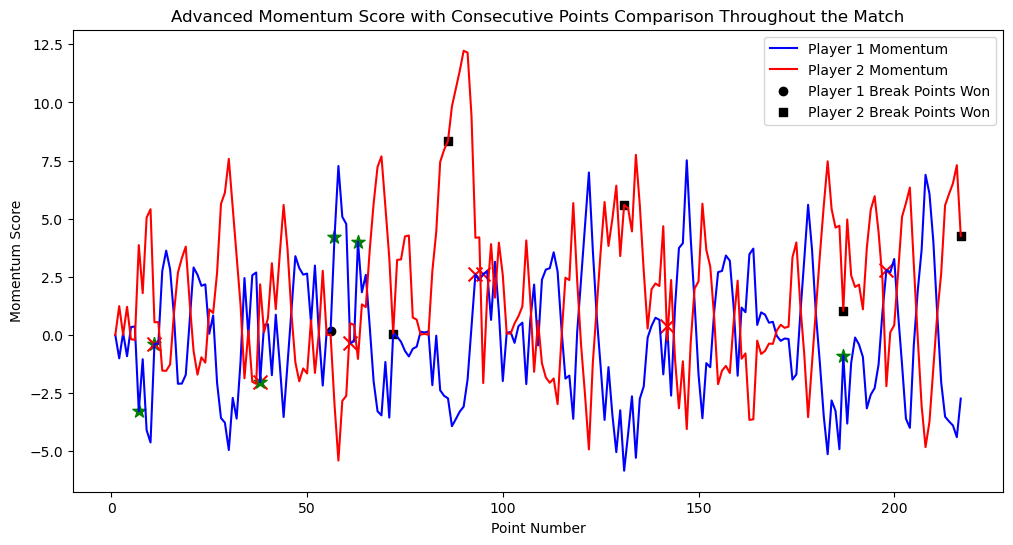

Player 1 had a Positive shift at point number 48, during set 1, game 9. GET 4.00604043715847
Player 1 had a Positive shift at point number 68, during set 2, game 3. GET 4.205714754098361
Player 1 had a Negative shift at point number 72, during set 2, game 3. GET -4.1445530054644815
Player 1 had a Negative shift at point number 78, during set 2, game 4. GET -5.3662841530054655
Player 1 had a Negative shift at point number 117, during set 3, game 3. GET -7.320794535519125
Player 1 had a Negative shift at point number 123, during set 3, game 4. GET -6.113289071038251
Player 1 had a Positive shift at point number 130, during set 3, game 6. GET 4.378475409836065
Player 1 had a Negative shift at point number 146, during set 3, game 7. GET -4.349497267759563
Player 2 had a Negative shift at point number 68, during set 2, game 3. GET -4.00571475409836
Player 2 had a Positive shift at point number 72, during set 2, game 3. GET 4.244553005464481
Player 2 had a Negative shift at point number 134,

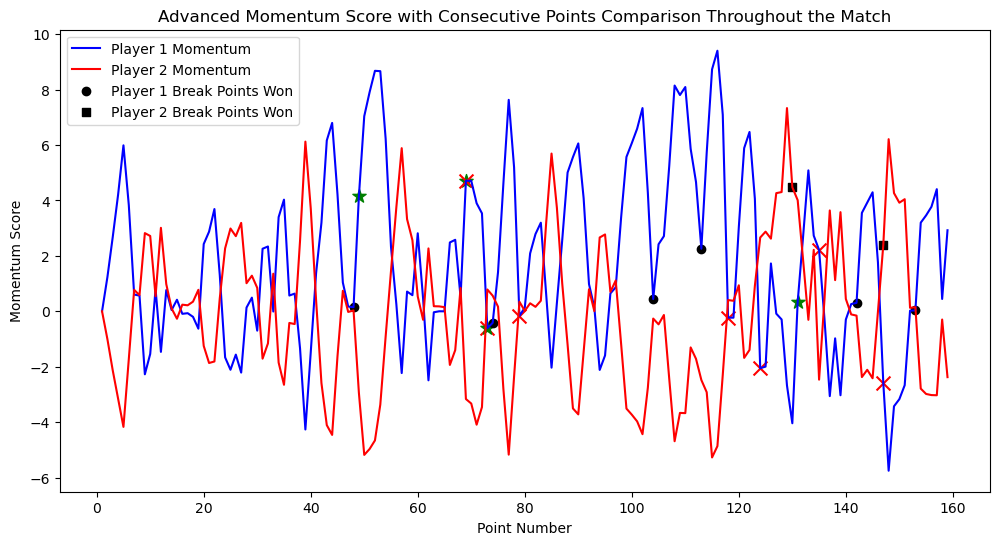

Player 2 had a Positive shift at point number 82, during set 2, game 5. GET 4.524642076502731
Player 2 had a Negative shift at point number 86, during set 2, game 5. GET -4.677027322404371
Player 2 had a Negative shift at point number 135, during set 3, game 3. GET -4.145949726775957


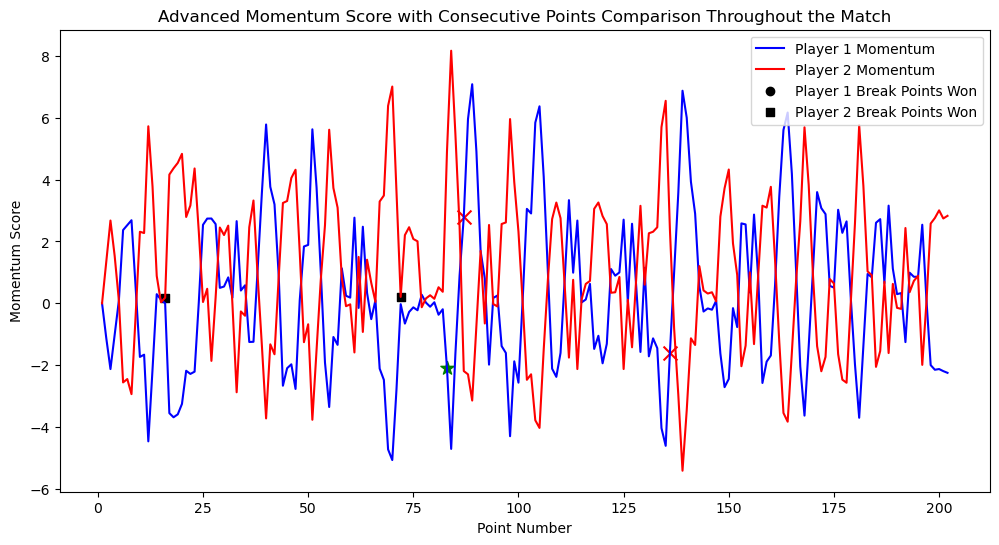

Player 1 had a Positive shift at point number 24, during set 1, game 4. GET 4.336087978142077
Player 1 had a Negative shift at point number 54, during set 2, game 2. GET -4.203821857923497
Player 1 had a Negative shift at point number 64, during set 2, game 3. GET -4.853044808743169
Player 1 had a Negative shift at point number 74, during set 2, game 4. GET -5.6222666666666665
Player 1 had a Positive shift at point number 78, during set 2, game 5. GET 5.629645355191256
Player 1 had a Negative shift at point number 148, during set 3, game 2. GET -4.237975956284153
Player 1 had a Negative shift at point number 157, during set 3, game 3. GET -5.010643715846994
Player 1 had a Negative shift at point number 203, during set 3, game 6. GET -4.7644360655737685
Player 1 had a Negative shift at point number 208, during set 3, game 7. GET -4.326276502732242
Player 1 had a Positive shift at point number 215, during set 4, game 2. GET 6.096496721311475
Player 1 had a Negative shift at point number 

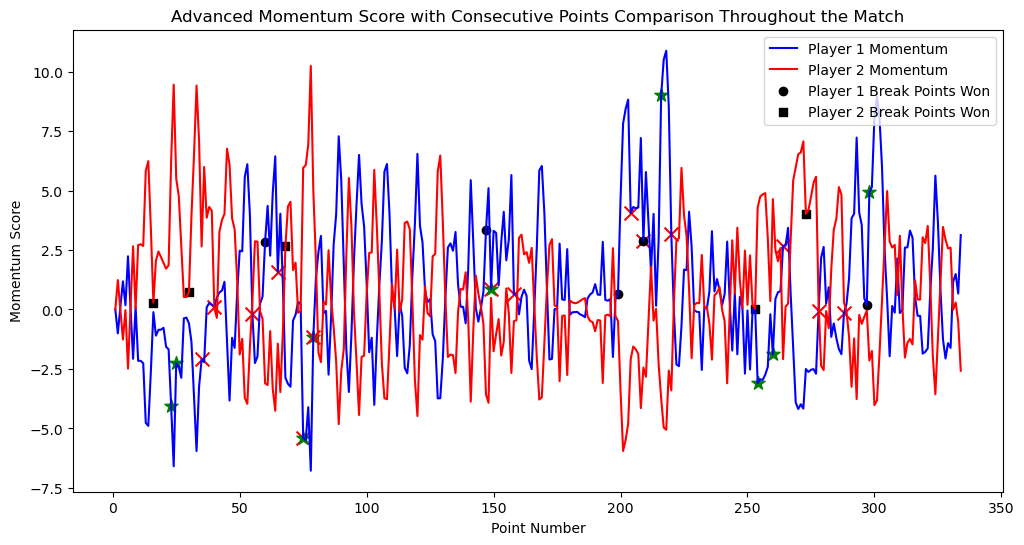

In [5]:
for target_match_id in target_match_ids:
    # 筛选数据
    filtered_data = df[df['match_id'] == target_match_id].copy()
    
    # 计算综合势头得分
    filtered_data['comprehensive_momentum_1'] = calculate_comprehensive_momentum(filtered_data, player_number=1)
    filtered_data['comprehensive_momentum_2'] = calculate_comprehensive_momentum(filtered_data, player_number=2)
    
    # Define the threshold for a significant momentum shift
    threshold = 4
    
    # Initialize lists to store the points of positive and negative shifts for both players
    shifts_player_1 = []
    shifts_player_2 = []
    
    # Calculate the momentum change for each point and find shifts
    for i in range(1, len(filtered_data)):
        change_1 = filtered_data['comprehensive_momentum_1'].iloc[i] - filtered_data['comprehensive_momentum_1'].iloc[i - 1]
        change_2 = filtered_data['comprehensive_momentum_2'].iloc[i] - filtered_data['comprehensive_momentum_2'].iloc[i - 1] 
            
        if abs(change_1) >= threshold:
            shift_type = 'Positive' if change_1 > 0 else 'Negative'
            shifts_player_1.append((i, shift_type, change_1))
        if abs(change_2) >= threshold:
            shift_type = 'Positive' if change_2 > 0 else 'Negative'
            shifts_player_2.append((i, shift_type, change_2))
    
    # Annotation
    for point, shift_type, change in shifts_player_1:
        set_no = filtered_data['set_no'].iloc[point]
        game_no = filtered_data['game_no'].iloc[point]
        print(f"Player 1 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")
    
    for point, shift_type, change in shifts_player_2:
        set_no = filtered_data['set_no'].iloc[point]
        game_no = filtered_data['game_no'].iloc[point]
        print(f"Player 2 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}. GET {change}")
    
    # 筛选出破发成功的点
    break_points_won_1 = filtered_data[filtered_data['p1_break_pt_won'] == 1]
    break_points_won_2 = filtered_data[filtered_data['p2_break_pt_won'] == 1]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_1'], label='Player 1 Momentum', color='blue')
    plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_2'], label='Player 2 Momentum', color='red')
    
    for point, shift_type, _ in shifts_player_1:
        marker = '*' if shift_type == 'Positive' else 'x'
        color = 'green' if shift_type == 'Positive' else 'red'
        plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point], 
                    color=color, marker=marker, s=100)
    
    for point, shift_type, _ in shifts_player_2:
        marker = '*' if shift_type == 'Positive' else 'x'
        color = 'green' if shift_type == 'Positive' else 'red'
        plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point], 
                    color=color, marker=marker, s=100)
    
    # 用黑色点标记破发成功的点
    plt.scatter(break_points_won_1['point_no'], break_points_won_1['comprehensive_momentum_1'], color='black', marker='o', label='Player 1 Break Points Won')
    plt.scatter(break_points_won_2['point_no'], break_points_won_2['comprehensive_momentum_2'], color='black', marker='s', label='Player 2 Break Points Won')
    
    # Add labels and title to the plot
    plt.xlabel('Point Number')
    plt.ylabel('Momentum Score')
    plt.title('Advanced Momentum Score with Consecutive Points Comparison Throughout the Match')
    plt.legend()
    plt.show()
    
    filename = 'data_with_momentum/' + target_match_id + '.csv'
    # filtered_data.to_csv(filename, index=False)

**v3.0 let threshold = 8, window = 3**

1. 66
    1 -8.76, 2 +8.36    1发球，2胜  40-30 -> 40-40
2. 74
    1 -12.24, 2 +12.09  2发球，2胜  40-30 -> 40-40  跑动距离尤其长（双方平均不到20，120-93），拍数多（29，平均4.46）
3. ...

    峰谷值体现在多拍回合，说明要降低拍数和跑动距离的影响。


**v3.1 let threshold = 4, window = 3， 调整拍数和跑动距离部分的系数**
1. 218
    1 -5.33             2发球，2胜 30-0 -> 30-15
2. ...

    个人觉得大致可以自圆其说，还要增加破发/保发的特征

**v3.2 ...**
1. ...  